# Mini-Meta Delta

> Explanation of how to compute the meta-analyzed weighted effect size using dabest.

- order: 4

When scientists conduct replicates of the same experiment, the effect size of each replicate often varies, complicating the interpretation of the results. Starting from v2023.02.14, DABEST can now compute the meta-analyzed weighted effect size given multiple replicates of the same experiment. This can help resolve differences between replicates and simplify interpretation.

This function employs the generic *inverse-variance* method to calculate the effect size, as follows:

$\theta_{\text{weighted}} = \frac{\Sigma\hat{\theta_{i}}w_{i}}{{\Sigma}w_{i}}$

where:


$\hat{\theta_{i}} = \text{Mean difference for replicate }i$


$w_{i} = \text{Weight for replicate }i = \frac{1}{s_{i}^2}$ 


$s_{i}^2 = \text{Pooled variance for replicate }i = \frac{(n_{test}-1)s_{test}^2+(n_{control}-1)s_{control}^2}{n_{test}+n_{control}-2}$


$n = \text{sample size and }s^2 = \text{variance for control/test.}$


Note that this utilizes the fixed-effects model of meta-analysis, in contrast to the random-effects model. In the fixed-effects model, all variation between the results of each replicate is assumed to be solely due to sampling error. Therefore, we recommend using this function exclusively for replications of the same experiment, where it can be safely assumed that each replicate estimates the same population mean $\mu$.

Additionally, be aware that as of v2023.02.14, DABEST can only compute weighted effect size *for mean difference only*, and not for standardized measures such as Cohen's *d*.

For more information on meta-analysis, please refer to Chapter 10 of the Cochrane handbook: https://training.cochrane.org/handbook/current/chapter-10


## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import dabest

print("We're using DABEST v{}".format(dabest.__version__))

We're using DABEST v2023.03.29


In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # to suppress warnings related to points not being able to be plotted due to dot size

## Create dataset for mini-meta demo

Let´s create a dataset to demonstrate the mini-meta function.

In [ ]:
from scipy.stats import norm # Used in generation of populations.

np.random.seed(9999) # Fix the seed to ensure reproducibility of results.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)

t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)


# Add a `gender` column for coloring the data.
females = np.repeat('Female', Ns/2).tolist()
males = np.repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3,
                   'Gender'    : gender, 'ID'  : id_col
                  })

We now have three *Control* and three *Test* groups, simulating three replicates of the same experiment. Our
dataset has also a non-numerical column indicating gender, and another
column indicating the identity of each observation.

This is known as a 'wide' dataset. See this
[writeup](https://sejdemyr.github.io/r-tutorials/basics/wide-and-long/)
for more details.

In [ ]:
df.head()

,Control 1,Test 1,Control 2,Test 2,Control 3,Test 3,Gender,ID
0,2.793984,3.420875,3.324661,1.707467,3.816940,1.796581,Female,1
1,3.236759,3.467972,3.685186,1.121846,3.750358,3.944566,Female,2
2,3.019149,4.377179,5.616891,3.301381,2.945397,2.832188,Female,3
3,2.804638,4.564780,2.773152,2.534018,3.575179,3.048267,Female,4
4,2.858019,3.220058,2.550361,2.796365,3.692138,3.276575,Female,5


## Loading data

Next, we load data as usual using ``dabest.load()``. However, this time, we also specify the argument ``mini_meta=True``. Since we are loading data from three experiments, ``idx`` is passed as a tuple of tuples, as shown below:

In [ ]:
unpaired = dabest.load(df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), mini_meta=True)

When this ``Dabest`` object is invoked, it should indicate that effect sizes will be calculated for each group, along with the weighted delta. It is important to note once again that the weighted delta will only be calculated for mean differences

In [ ]:
unpaired

DABEST v2023.03.29
                  
Good evening!
The current time is Thu Feb  1 23:38:39 2024.

Effect size(s) with 95% confidence intervals will be computed for:
1. Test 1 minus Control 1
2. Test 2 minus Control 2
3. Test 3 minus Control 3
4. weighted delta (only for mean difference)

5000 resamples will be used to generate the effect size bootstraps.

By calling the ``mean_diff`` attribute, you can view the mean differences for each group as well as the weighted delta.


In [ ]:
unpaired.mean_diff

DABEST v2023.03.29
                  
Good evening!
The current time is Thu Feb  1 23:38:41 2024.

The unpaired mean difference between Control 1 and Test 1 is 0.48 [95%CI 0.221, 0.768].
The p-value of the two-sided permutation t-test is 0.001, calculated for legacy purposes only. 

The unpaired mean difference between Control 2 and Test 2 is -1.38 [95%CI -1.93, -0.895].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The unpaired mean difference between Control 3 and Test 3 is -0.255 [95%CI -0.717, 0.196].
The p-value of the two-sided permutation t-test is 0.293, calculated for legacy purposes only. 

The weighted-average unpaired mean differences is -0.0104 [95%CI -0.222, 0.215].
The p-value of the two-sided permutation t-test is 0.937, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or

You can view the details of each experiment by accessing the property `mean_diff.results` as follows.

In [ ]:
pd.options.display.max_columns = 50
unpaired.mean_diff.results

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,bca_interval_idx,pct_low,pct_high,pct_interval_idx,bootstraps,resamples,random_seed,permutations,pvalue_permutation,permutation_count,permutations_var,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Control 1,Test 1,20,20,mean difference,None,0.480290,95,0.220869,0.767721,"(140, 4889)",0.215697,0.761716,"(125, 4875)","[0.6686169333655454, 0.4382051534234943, 0.665...",5000,12345,"[-0.17259843762502491, 0.03802293852634886, -0...",0.0010,5000,"[0.026356588154404337, 0.027102495439046997, 0...",0.002094,-3.308806,0.002057,-3.308806,0.001625,83.0
1,Control 2,Test 2,20,20,mean difference,None,-1.381085,95,-1.925232,-0.894537,"(108, 4857)",-1.903964,-0.875420,"(125, 4875)","[-1.1603841133810318, -1.6359724856206515, -1....",5000,12345,"[0.015164519971271773, 0.017231919606192303, -...",0.0000,5000,"[0.12241741427801064, 0.12241565174150129, 0.1...",0.000011,5.138840,0.000009,5.138840,0.000026,356.0
2,Control 3,Test 3,20,20,mean difference,None,-0.254831,95,-0.717337,0.196121,"(115, 4864)",-0.710346,0.206131,"(125, 4875)","[-0.09556572841011901, 0.35166073097757433, -0...",5000,12345,"[-0.05901068591042824, -0.13617667681797307, 0...",0.2934,5000,"[0.058358897501663703, 0.05796253365278035, 0....",0.294766,1.069798,0.291459,1.069798,0.285305,240.0


Note, however, that this does not contain the relevant information for our weighted delta. The details of the weighted delta are stored as attributes of the ``mini_meta_delta`` object, such as:

  - ``group_var``: the pooled group variances of each set of 2 experiment groups.
  - ``difference``: the weighted mean difference calculated based on the raw data.
  - ``bootstraps``: the deltas of each set of 2 experiment groups calculated based on the bootstraps.
  - ``bootstraps_weighted_delta``: the weighted deltas calculated based on the bootstraps.
  - ``permutations``: the deltas of each set of 2 experiment groups calculated based on the permutation data.
  - ``permutations_var``: the pooled group variances of each set of 2 experiment groups calculated based on permutation data.
  - ``permutations_weighted_delta``: the weighted deltas calculated based on the permutation data.

You can call each of the above attributes individually:

In [ ]:
unpaired.mean_diff.mini_meta_delta.difference

-0.01035228770106855

Attributes of the weighted delta can also be recorded in a `dict` using the ``to_dict()`` function. Here, we demonstrate this process and then convert the generated dictionary into a dataframe for enhanced readability:


In [ ]:
weighted_delta_details = unpaired.mean_diff.mini_meta_delta.to_dict()
weighted_delta_df = pd.DataFrame.from_dict(weighted_delta_details, orient = 'index')
weighted_delta_df

,0
acceleration_value,0.000193
alpha,0.05
bca_high,0.215037
bca_interval_idx,"(128, 4878)"
bca_low,-0.221666
bias_correction,0.005013
bootstraps,"[[0.6686169333655454, 0.4382051534234943, 0.66..."
bootstraps_weighted_delta,"[0.1771640316740503, 0.05505265333097302, 0.16..."
ci,95
control,"[Control 1, Control 2, Control 3]"


## Generating estimation plots - unpaired data

Calling the ``plot()`` method produces a **Cumming estimation plot** showing the data for each experimental replicate as well as the calculated weighted delta.


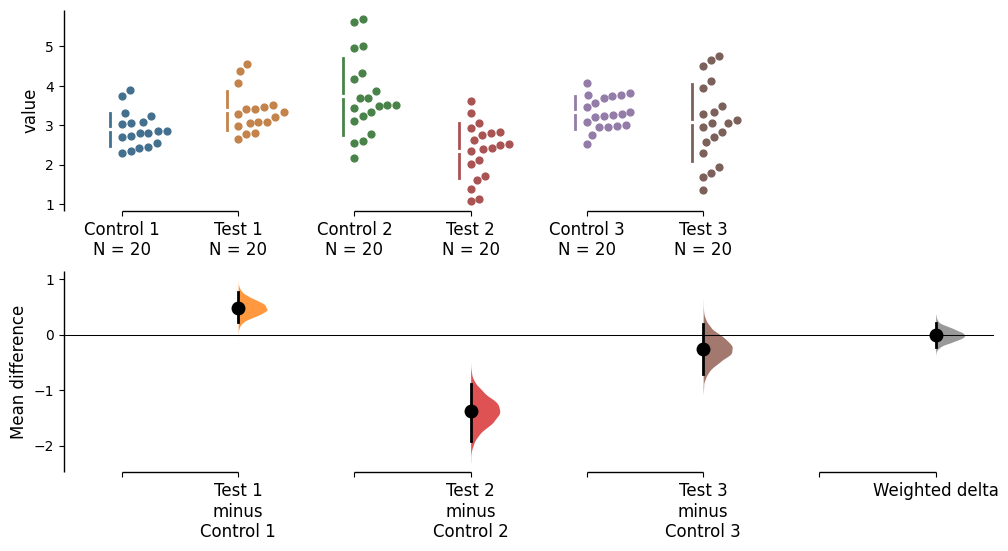

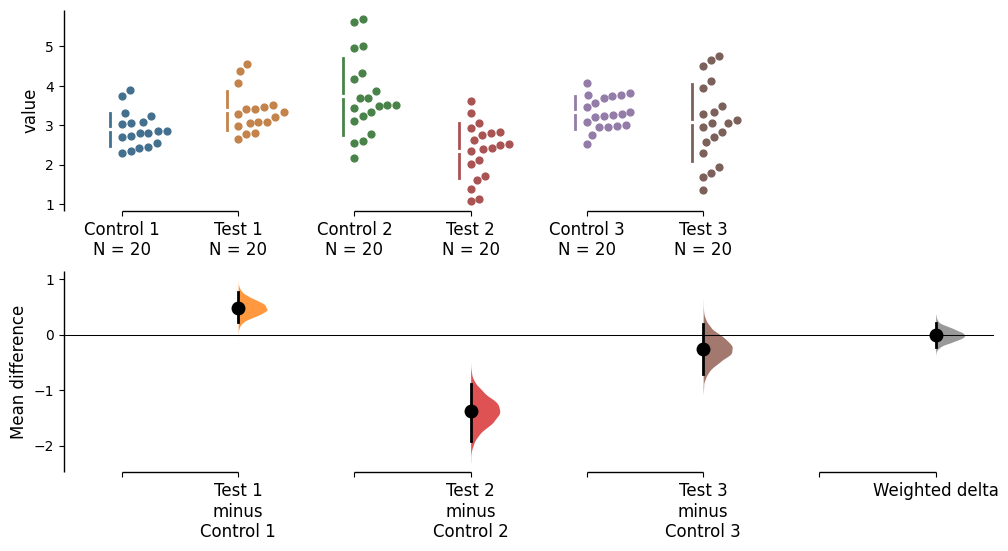

In [ ]:
unpaired.mean_diff.plot()

You can also hide the weighted delta by passing the argument ``show_mini_meta=False``. In this case, the resulting graph would be identical to a multiple two-groups plot:


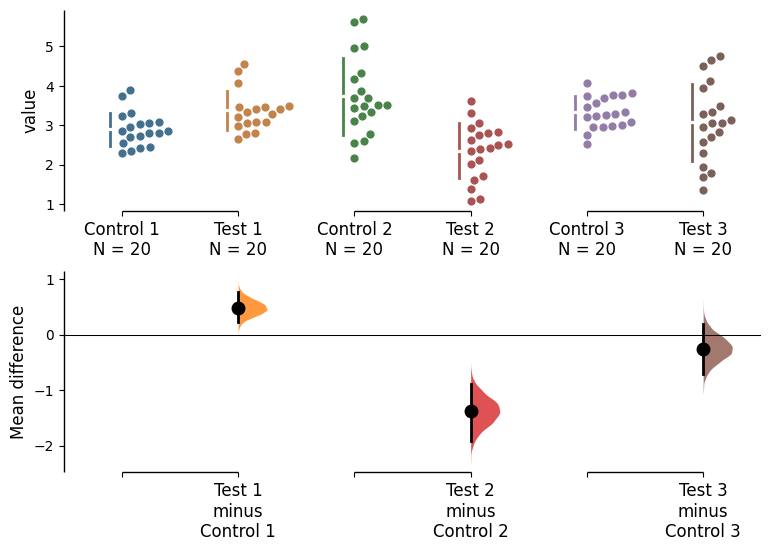

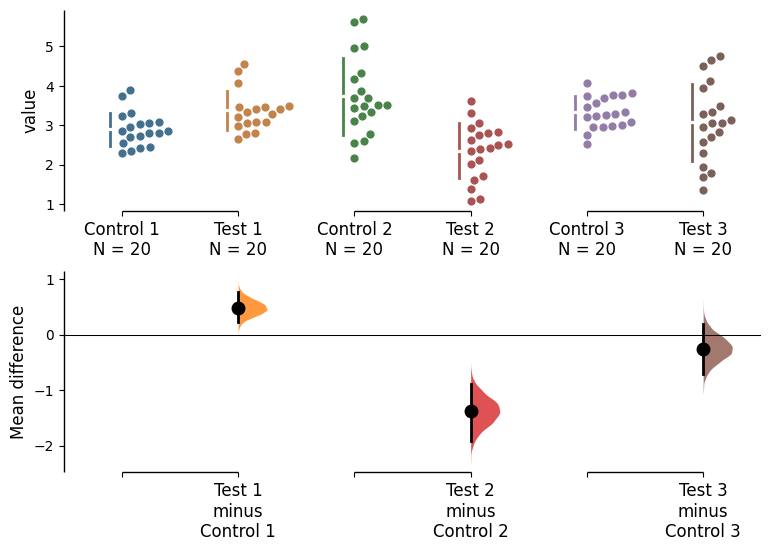

In [ ]:
unpaired.mean_diff.plot(show_mini_meta=False)

## Producing estimation plots - paired data

The tutorial up to this point has focused on unpaired data. If your data is paired, the process for loading, plotting, and accessing the data is similar to that for unpaired data, with the exception that the argument ``paired="sequential"`` or ``paired="baseline"`` and an appropriate ``id_col`` are passed during the ``dabest.load()`` step, as shown below:

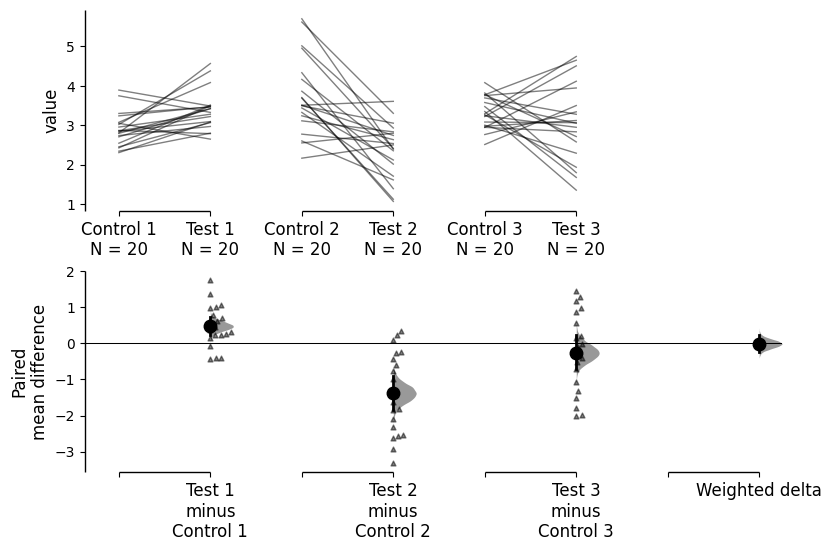

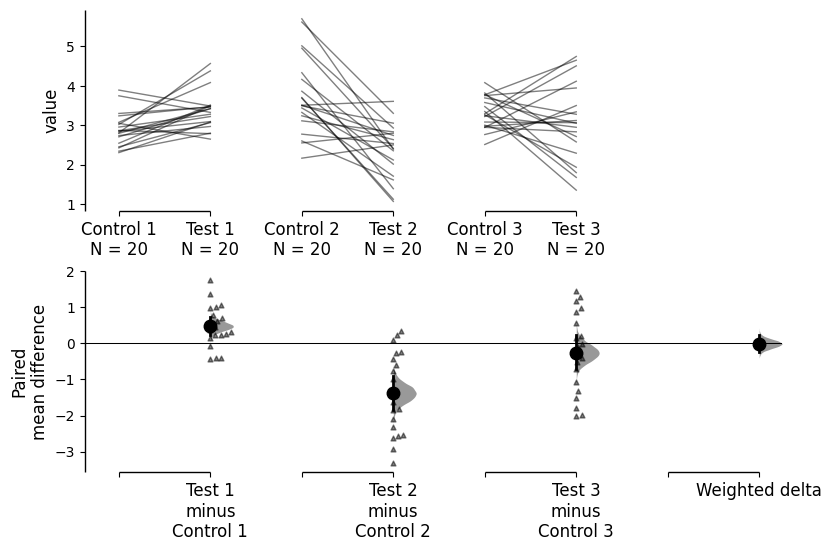

In [ ]:
paired = dabest.load(df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), mini_meta=True, id_col="ID", paired="baseline")
paired.mean_diff.plot()